In [35]:
import import_ipynb
import model_nt
import torch
import numpy as np

model = model_nt.NewsTechLSTM()
model.load_state_dict(torch.load("best_news_tech_model.pt"))
model.eval()

NewsTechLSTM(
  (conv1): Conv1d(100, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (news_lstm): LSTM(64, 128, batch_first=True)
  (tech_lstm): LSTM(7, 64, batch_first=True)
  (fc): Linear(in_features=192, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [36]:
import layers_nt
import yfinance as yf
import pandas as pd

technical_indicators = layers_nt.calculate_technical_indicator(start_date='2019-05-31', end_date='2020-06-01')
trading_days = pd.to_datetime(technical_indicators['Date']).dt.tz_localize(None).dt.date
daily_news_trading_days = layers_nt.calculate_embedding_layer('test2020.csv',trading_days)

merged = technical_indicators
merged['sentence_vector'] = daily_news_trading_days['sentence_vector']

[*********************100%***********************]  1 of 1 completed


In [37]:
initial_capital = 1000
buy_hold_capital = [initial_capital]
model_capital = [initial_capital]

capital = initial_capital
in_position = False  # Whether we "buy" based on model

lookback = 3

for i in range(lookback, len(merged) - 1):
    # Prepare input sequences
    news_seq = np.stack(merged['sentence_vector'].iloc[i-lookback:i].values)
    tech_seq = merged[['Stochastic_%K', 'Williams_%R', 'Stochastic_%D','AD_Oscillator', 'Momentum', 'Disparity', 'ROC']].iloc[i-lookback:i].values

    news_tensor = torch.tensor(news_seq[np.newaxis, ...], dtype=torch.float32)
    tech_tensor = torch.tensor(tech_seq[np.newaxis, ...], dtype=torch.float32)

    # Predict movement for the next day
    with torch.no_grad():
        out = model(news_tensor, tech_tensor)
        pred = torch.argmax(out, dim=1).item()  # 1 = up, 0 = down

    today_close = merged['Close'].iloc[i].values[0]
    next_close = merged['Close'].iloc[i + 1].values[0]
    pct_change = (next_close - today_close) / today_close

    # Update model strategy capital
    if pred == 1:
        capital = capital * (1 + pct_change)
    # elif pred == 0:  # model says down: short!
    #     capital = capital * (1 - pct_change)  # "shorting" the market
    # If pred == 0, we stay in cash, capital remains the same
    model_capital.append(capital)

    # Buy & hold capital (always fully invested)
    buy_hold_capital.append(buy_hold_capital[-1] * (1 + pct_change))

# Final results
final_model_cap = model_capital[-1]
final_bh_cap = buy_hold_capital[-1]

print(f"\nFinal Capital (Model Strategy): ${final_model_cap:.2f}")
print(f"Final Capital (Buy & Hold): ${final_bh_cap:.2f}")


Final Capital (Model Strategy): $786.71
Final Capital (Buy & Hold): $1077.19


Here we plot the capital movements as influenced by our predictor when compared to a baseline of the "Buy & Hold" Strategy on the S&P 500.

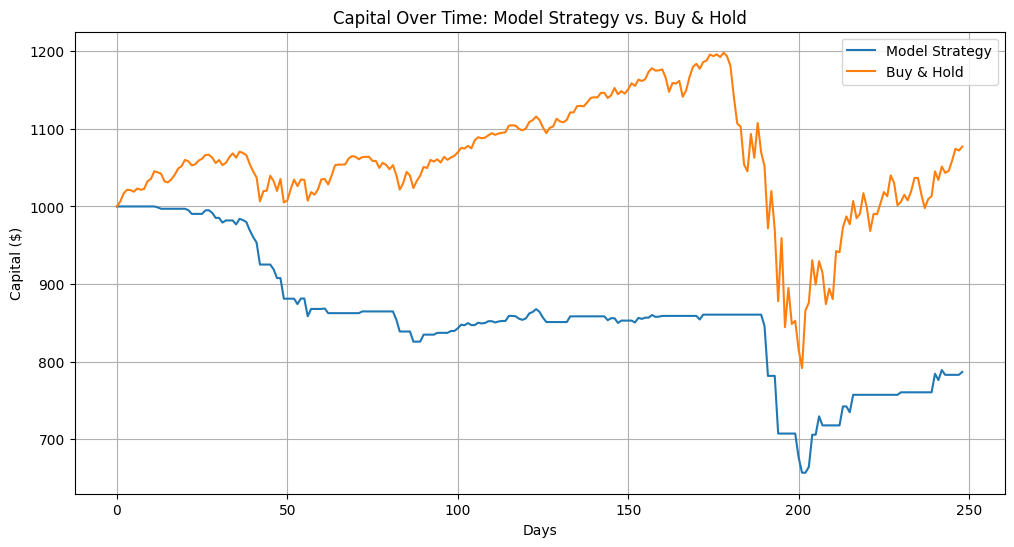

In [38]:
import matplotlib.pyplot as plt

model_capital = [x['^GSPC'] if isinstance(x, pd.Series) else x for x in model_capital]
buy_hold_capital = [x['^GSPC'] if isinstance(x, pd.Series) else x for x in buy_hold_capital]
plt.figure(figsize=(12,6))
plt.plot(model_capital, label='Model Strategy')
plt.plot(buy_hold_capital, label='Buy & Hold')
plt.xlabel('Days')
plt.ylabel('Capital ($)')
plt.title('Capital Over Time: Model Strategy vs. Buy & Hold')
plt.legend()
plt.grid()
plt.show()

In [39]:
model_capital

[1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 998.7407772074806,
 997.0110710286115,
 997.0110710286115,
 997.0110710286115,
 997.0110710286115,
 997.0110710286115,
 997.0110710286115,
 997.0110710286115,
 997.0110710286115,
 995.2105671418082,
 990.3982817533789,
 990.3982817533789,
 990.3982817533789,
 990.3982817533789,
 994.9740946870048,
 995.149079976658,
 991.7618129118604,
 985.2843749488528,
 985.2843749488528,
 979.1985349353637,
 981.9683888519761,
 981.9683888519761,
 981.9683888519761,
 976.8008771451166,
 984.0171802909263,
 982.4268957521867,
 979.8935558089966,
 969.2268989195754,
 960.5050258432557,
 953.5099175414265,
 925.1164708458159,
 925.1164708458159,
 925.1164708458159,
 925.1164708458159,
 918.995339325773,
 907.6757776512426,
 907.6757776512426,
 881.0874553725309,
 881.0874553725309,
 881.0874553725309,
 881.0874553725309,
 874.1138881704834,
 881.3225293558244,
 881.3225293558244,
 858.4554382197264,
 867.8838437689234